# Setup

## Import packages

In [2]:
import osmnx as ox # open street maps
import geopandas as gpd # geodata wrangling
import pandas as pd # data wrangling
import numpy as np
import pyomo.environ as pyo # solver
import shapely # even more geodata wrangling
import gurobipy as gp # solver 2
from gurobipy import GRB

from scipy.spatial.distance import cdist # makes the distance matrix computation fast

# these should be included with shapely, right?
from shapely.geometry import LineString # creates LineString geometry objects
from shapely.geometry import Point # creates Point geometry objects

## Load data

In [9]:
# Lexington-Fayette-Urban County Government Urban Service Area
# https://hub.arcgis.com/datasets/4c8db8e014cb49349fd430d96d8994b9_0/about
city_boundary_gdf = (
    gpd.read_file('bike-lanes-optimization/data/lfucg_usb/Urban_Service_Area.shp')
    .to_crs('EPSG:4326') # project to classic CRS
)
city_boundary=city_boundary_gdf.geometry.iloc[0]

In [1244]:
# US census data
# census block geometry
census_blocks_gdf = (
    gpd
    .read_file('bike-lanes-optimization/data/tl_2020_21067_tabblock20/tl_2020_21067_tabblock20.shp')
    .assign(in_USB=lambda df: df['geometry'].within(city_boundary)) # define a truth column
    .query("in_USB == True") # select only blocks inside the USB
    .query("GEOID20 != '210670040061008'") # exclude a specific block 
    # the above block is rural in appearance, and quite far from any bike network nodes (770m)
)
# population data
population_df = (
    pd
    .read_csv('bike-lanes-optimization/data/DECENNIALPL2020.H1_2024-04-02T135509/DECENNIALPL2020.H1-Data.csv')
    .query('GEO_ID != "Geography"') # data has a "header" row
    .drop_duplicates() # original data has 101 duplicate rows 
)
# https://api.census.gov/data/2020/dec/pl/variables.html for more info 

In [1245]:
# list of arcs to remove from the bike network
arc_exclude_list = [
    83568, # disconnects census block 210670026005001
    126616, # golf course; disconnects census block 210670019001020
    126608, # golf course; disconnects census block 210670019001003
    126612, # golf course; disconnects census block 210670019001002
    60836, # parking lot; disconnects census block 210670019002002
    60835, # parking lot; disconnects census block 210670019002002
    62039, # parking lot; disconnects census block 210670019002002
    79572, # parking lot; disconnects census block 210670010002002
    85764, # parking lot; disconnects census block 210670010002002
    116486, # sidewalk; disconnects census block 210670039084042
    98492, # sidewalk; disconnects census block 210670039084042
    126711, # golf course; disconnects census block 210670034052004
    126398, # golf course; disconnects census block 210670034052003
    81467, # parking lot; disconnects census block 210670041053003 
    81468, # parking lot; disconnects census block 210670041053003 
    81469, # parking lot; disconnects census block 210670041053003 
    81471, # parking lot; disconnects census block 210670041053003 
    81472, # parking lot; disconnects census block 210670041053003 
    81477, # parking lot; disconnects census block 210670041053003 
    119911, # parking lot; disconnects census block 210670041053003 
    59819, # sidewalk; disconnects census block 210670001011027
    57257, # sidewalk; disconnects census block 210670001011027
    59818, # sidewalk; disconnects census block 210670001011008
    65637, # parking lot; disconnects census block 210670003003006
    50229, # sidewalk; disconnects census block 210670004002004
    50111, # sidewalk; disconnects census block 210670004002004
    59541, # sidewalk; disconnects census block 210670018002015
    54569, # sidewalk; disconnects census block 210670018002015
    54180, # sidewalk; disconnects census block 210670008022002
    73268, # parking lot; disconnects census block 210670007001013
    73296, # parking lot; disconnects census block 210670007001013
    73294, # parking lot; disconnects census block 210670007001013
    73292, # parking lot; disconnects census block 210670007001013
    71562, # parking lot; disconnects census block 210670007002002
    74034, # parking lot; disconnects census block 210670007002002
    126440, # golf course; disconnects census block 210670017002000
    126441, # golf course; disconnects census block 210670017002000
    126442, # golf course; disconnects census block 210670017002000
    126443, # golf course; disconnects census block 210670017002000
    126444, # golf course; disconnects census block 210670017002000
    126445, # golf course; disconnects census block 210670017002000
    126446, # golf course; disconnects census block 210670017002000
    126447, # golf course; disconnects census block 210670017002000
    126448, # golf course; disconnects census block 210670017002000
    126449, # golf course; disconnects census block 210670017002000
    126450, # golf course; disconnects census block 210670017002000
    81470, # parking lot; disconnects census block 210670041053003
    83569, # parking lot; disconnects census block 210670026005001
    83571, # parking lot; disconnects census block 210670026005001
    83569, # parking lot; disconnects census block 210670026005001
    62068, # parking lot; disconnects census block 210670019002002
    62071, # parking lot; disconnects census block 210670019002002
    60837, # parking lot; disconnects census block 210670019002002
    50232, # sidewalk; disconnects census block 210670004002004
    58492, # sidewalk; disconnects census block 210670004002004
    126397, # golf course; disconnects census block 210670034052003
    58109, # sidewalk; disconnects census block 210670001021003; maybe
    59254, # sidewalk;disconnects census block 210670001021003; maybe
    126396, # golf course; disconnects census block 210670034052003
    126397, # golf course; disconnects census block 210670034052003
    126710, # golf course; disconnects census block 210670034052003
    71233, # golf course; disconnects census block 210670034052003
    72867, # golf course; disconnects census block 210670034052003
    72868, # golf course; disconnects census block 210670034052003
    72869, # golf course; disconnects census block 210670034052003
    72870, # golf course; disconnects census block 210670034052003
    79919, # parking lot; disconnects census block 210670040013000; maybe
    79918, # parking lot; disconnects census block 210670040013000; maybe
    79921, # parking lot; disconnects census block 210670040013000; maybe
    79917, # parking lot; disconnects census block 210670040013000; maybe
    114815, # parking lot; disconnects census block 210670032021009; maybe
    109752, # parking lot; disconnects census block 210670032021009; maybe
    109753, # parking lot; disconnects census block 210670032021009; maybe
    106337, # parking lot; disconnects census block 210670038023034; maybe
    106339, # parking lot; disconnects census block 210670038023034; maybe
    106338, # parking lot; disconnects census block 210670038023034; maybe
    101567, # parking lot; disconnects census block 210670038023034; maybe
    106340, # parking lot; disconnects census block 210670038023034; maybe
]

In [1246]:
# PeopleForBikes cycle network data
pfb_gdf = (
    gpd.read_file('bike-lanes-optimization/data/people_for_bikes/neighborhood_ways/neighborhood_ways.shp')
    .query('ROAD_ID not in @arc_exclude_list') # remove disconnected edges from the network
    .query("FUNCTIONAL != 'motorway'") # remove the highways
    .query("FUNCTIONAL != 'motorway_link'") # exit ramps etc.
)

In [1247]:
# list of amenities to exclude based on local knowledge
# consider editing the source file directly 
dest_exclude_list = [
    'node/12001067429', # 'The Venue Shopping Center Courtyard' is not a real park
    'node/8520821500', # Speigle Heights Park has a node and a way
    'node/12001059631', # Zandale Park has a node and a way
    'node/3197373270' # Red Mile Horse training area isn't a 'park' in the sense we care about
]

In [1248]:
# amenity data
amenities_gdf = (
    gpd
    .read_file('bike-lanes-optimization/data/lex_parks_export.geojson')
    .cx[-84.6 : -84.3,  37.9 : 38.2] # filter non-KY Lexingtons using a bounding box
    .query('id not in @dest_exclude_list') # remove individual entries
    # consider adding (or replacing) this filter with the Urban Service Boundary
)

## Define parameters

In [1249]:
#threshold = 200 # radius for arcs (origin,intermediate) or (intermediate,dest)
# replace threshold variable with stratified list of radii for arcs (origin,intermediate) or (intermediate,dest)

radii = [50,100,150,200,250,300,400]  
# 301 bc there's one single block that is 371.something meters away from bike nodes (once motorways excluded)

# CRS projection for distance calculations?
# currently using Albers contiguous USA
#'ESRI:102003'

# budget 

# upgrade costs (in $million/mile)
cost_per_mile = 2 * 10**6 # $2mil/mi
cost_per_mile_modi = 2 * 10**6 # $2mil/mi; if not in H2 
cost_per_mile_bidi = 1 * 10**6 # $1mil/mi; if in H2 
# convert to $/m
cost_per_meter = cost_per_mile/1609.34
cost_per_meter_modi = cost_per_mile_modi/1609.34
cost_per_meter_bidi = cost_per_mile_bidi/1609.34

# exceedance factor f

# Data wrangling

## Create nodes

### Origin nodes: census blocks DEBUG ACTIVE (possibly)

In [1250]:
# DEBUG: try removing census blocks to identify disconnections
census_block_debug_list = [
    #'210670023022012',
    '210670032021009',
    '210670037042044',
    '210670038023034',
    '210670039062021',
    '210670039062023',
    '210670040013000' 
]

In [1251]:
# merge geo and pop data
origin_nodes_df = (
    # call population data
    population_df
    .assign(
        geoid20=lambda x: x['GEO_ID'].str.slice(9, 24), # reformat the geoid to match geoblocks_df
        H1_001N=lambda x: x['H1_001N'].astype(int) # convert to integer
    ) 
    
    # merge with census blocks geographic data 
    .merge(census_blocks_gdf, left_on='geoid20', right_on='GEOID20', how='left') 

    # create new columns
    .assign(
        name = lambda x: x['GEOID20'].str[-8:], # last eight digits of GEOID20
        node_type = 'origin'
    )

    # rename columns 
    .rename(columns={
        'GEOID20' : 'id_string',
        'H1_001N' : 'netflow', 
        'INTPTLAT20' : 'lat', 
        'INTPTLON20' : 'lon'
    })

    # select nodes with nonzero population
    .query("netflow > 0")

    # select points inside USB
    # this may be redundant given the query in census_blocks_gdf import 
    .assign(
        # define a Point so we can apply .within()
        geometry=lambda df: df.apply(
            lambda x: Point(x['lon'], x['lat']) if (pd.notna(x['lon']) and pd.notna(x['lat'])) else None,
            axis=1
        ),
        # define a truth column
        in_USB=lambda df: df['geometry'].apply(lambda point: city_boundary.contains(point))
    )
    .query("in_USB == True")

    # reset index — this removes skips in the index
    .reset_index()
    
    # select columns
    [['id_string','name','node_type','netflow','lat','lon']]

    # DEBUG: try removing census blocks to identify disconnections
    #.query('id_string not in @census_block_debug_list')
)

In [1252]:
# scratch

# find where debug-removed census blocks are reappearing
# 210670023022012,
# 210670032021009,
# 210670037042044,
# 210670038023034,
# 210670039062021,
# 210670039062023,
# 210670040013000 

origin_nodes_df.query("id_string == '210670042102013'")

,id_string,name,node_type,netflow,lat,lon
2570,210670042102013,42102013,origin,30,+37.9706947,-084.5501176


In [1253]:
# calculate the total population (for destination, dummy netflows)
# only include population from inside USB
total_pop = origin_nodes_df['netflow'].sum()

# old code
#old_total_pop = population_df['H1_001N'].astype(int).sum() # 148367

### Intermediate nodes: cycle network

In [1254]:
# pull PFB cycling network intersections
# these steps should be similar to latlon.ipynb

In [1255]:
# heads 
heads_identifiers_gdf = (
    pfb_gdf
    
    # select columns
    [['INTERSECTI','geometry']]
    
    # change data types, create new columns
    .assign(
        identifier = lambda x: x['INTERSECTI'].astype(int),
        geometry = lambda x: (x['geometry'].to_crs("EPSG:4326")), # convert to classic CRS
        coord = lambda x: (x['geometry'].apply(
            lambda line: (line.coords[0][1], line.coords[0][0]) if line else None) # grab first coord, switch order
        )
    )

    # select points inside USB
    .assign(
        # define a truth column
        in_USB=lambda df: df['geometry'].apply(lambda point: city_boundary.contains(point))
    )
    .query("in_USB == True")

    # re-select columns
    [['identifier','coord']]
)

In [1256]:
# tails
tails_identifiers_gdf = (
    pfb_gdf
    
    # select columns
    [['INTERSE_01','geometry']]
    
    # change data types, create new columns
    .assign(
        identifier = lambda x: x['INTERSE_01'].astype(int),
        geometry = lambda x: (x['geometry'].to_crs("EPSG:4326")), # convert to classic CRS
        coord = lambda x: (x['geometry'].apply(
            lambda line: (line.coords[-1][1], line.coords[-1][0]) if line else None) # grab last coord, switch order
        )
    )

    # select points inside USB
    .assign(
        # define a truth column
        in_USB=lambda df: df['geometry'].apply(lambda point: city_boundary.contains(point))
    )
    .query("in_USB == True")

    # re-select columns
    [['identifier','coord']]
)

In [1257]:
# combine into single (g)df
intermediate_nodes_df = (
    # concat
    pd.concat([heads_identifiers_gdf, tails_identifiers_gdf], axis=0, ignore_index=True)

    # remove duplicates — this can cause skips in the index
    .drop_duplicates()

    # reset index — this removes skips in the index
    .reset_index()

    # create new columns
    .assign(
        name = '', # blank for now, we just need this column to match the amenity gdf
        node_type = 'intermediate',
        netflow = 0, 
        lat = lambda x: x['coord'].apply(lambda x: x[0] if x else None),
        lon = lambda x: x['coord'].apply(lambda x: x[1] if x else None) 
    )

    # rename columns 
    .rename(columns={'identifier' : 'id_string'})

    # select columns
    [['id_string','name','node_type','netflow','lat','lon']]
)

### Destination nodes: amenities

In [1258]:
# pull OSM aminities
# for now we're querying externally via Overpass Turbo
# using parks to start

# open file from overpass turbo
dest_nodes_df = (
    amenities_gdf

    # create new columns
    .assign(
        node_type = 'destination',
        rep_point = lambda x: x['geometry'].representative_point(), # define representative point
        netflow = 0, 
        lat = lambda x: x['rep_point'].apply(lambda point: point.y if point else None), # extract lat
        lon = lambda x: x['rep_point'].apply(lambda point: point.x if point else None) # extract lon
    )

    # rename columns 
    .rename(columns={'id' : 'id_string'})

    # select points inside USB
    .assign(
        # define a truth column
        in_USB=lambda df: df['geometry'].apply(lambda point: city_boundary.contains(point))
    )
    .query("in_USB == True")

    # reset index — this removes skips in the index
    .reset_index()

    # select columns
    [['id_string','name','node_type','netflow','lat','lon']]
)

In [1259]:
# compute the total number of amenities (need for dummy node netflow)
num_amenity_nodes = dest_nodes_df.shape[0]

In [1260]:
# scratch
print(num_amenity_nodes)

121


### Dummy node

In [1261]:
# create dummy node (sink)
new_row = gpd.GeoDataFrame(
    {
        'id_string': 'dummy_node', # name it
        'name': 'dummy_node', 
        'node_type' : 'dummy_node',
        'netflow': -1*total_pop, # this balances the negative flows of the amenities, like a sink
        'lat': [0], # put it somewhere not in the network?
        'lon': [0] # put it somewhere not in the network?
    }
)

### Combine into a single DataFrame

In [1262]:
# combine into single gdf
nodes_df = pd.concat([origin_nodes_df, intermediate_nodes_df, dest_nodes_df, new_row], ignore_index=True)

## Create arcs

### Arcs from census blocks to bike network

In [1263]:
# project nodes to Albers contiguous USA

# project origin nodes
origin_nodes_projected_gdf = (
    # need a gdf
    gpd.GeoDataFrame(
        origin_nodes_df,  # original DataFrame
        geometry=gpd.points_from_xy(origin_nodes_df['lon'], origin_nodes_df['lat']),  # create geometry column
        crs='EPSG:4326'  # define the CRS (WGS84 for latitude/longitude)
    )
    
    # project to USAC AUAC
    .to_crs('ESRI:102003')
    
    # make the index a column so we can reference it later
    .reset_index() 
)

# project intermediate network nodes
intermediate_nodes_projected_gdf = (
    # need a gdf
    gpd.GeoDataFrame(
        intermediate_nodes_df,  # original dataframe
        geometry=gpd.points_from_xy(intermediate_nodes_df['lon'], intermediate_nodes_df['lat']),
        crs='EPSG:4326'  # define the CRS (WGS84 for latitude/longitude)
    )
    
    # project to USAC AUAC
    .to_crs('ESRI:102003')
    
    # make the index a column so we can reference it later
    .reset_index() 
)

In [1264]:
# extract coordinates of geometries
origin_coords = np.array([geom.coords[0] for geom in origin_nodes_projected_gdf.geometry])
intermediate_coords = np.array([geom.coords[0] for geom in intermediate_nodes_projected_gdf.geometry])

# compute pairwise distances
oi_distance_matrix = cdist(origin_coords, intermediate_coords) 

In [1265]:
# identify (origin,intermediate) pairs within stratified radii

# stack matrix into a DataFrame
oi_distance_df = (
    # convert matrix to df object
    pd.DataFrame(
        oi_distance_matrix,
        index = origin_nodes_projected_gdf.index,  # use census block indices
        columns = intermediate_nodes_projected_gdf.index  # use cycle network node indices
    )
    .stack() # change shape so distance is a column
    .reset_index()  # unstack to have row-column pairs 
    .rename(columns={'level_0': 'row_index', 'level_1': 'col_index', 0: 'distance'})
)

# initialize list to fill with connected pairs (origin, destination, radius)
# use list instead of DataFrame for the sake of memory
oi_index_pairs_list = []

for r in radii:
    # identify idex pairs with distance <= r
    new_oi_pairs_list = (
        oi_distance_df
        .query('distance <= @r')  # filter distances 
        .assign(radius=r) # keep track of radius
        .values.tolist() # convert to list
    )
    
    # concatenate new index pairs and radius to oi_index_pairs_list
    oi_index_pairs_list = oi_index_pairs_list + new_oi_pairs_list 
    
    # determine which origin nodes have been connected
    new_origins_list = list({tup[0] for tup in new_oi_pairs_list})

    # update oi_distance_df to exclude newly connected origin nodes
    oi_distance_df = oi_distance_df[~oi_distance_df['row_index'].isin(new_origins_list)]
    
    # debugging stuff
    #print(f"radius: {r}")
    #print(f"length of new_oi_pairs_list: {len(new_oi_pairs_list)}")
    #print(f"length of oi_index_pairs_list: {len(oi_index_pairs_list)}")
    #print(f"length of new_origins_list: {len(new_origins_list)}")
    #print(f"remaining rows in oi_distance_df: {len(oi_distance_df)}")
    #print('')

In [1266]:
# use oi_index_pairs_list to create a new gdf of edges 

# construct a DataFrame
origin_to_intermediate_arcs_df = (
    # convert to DataFrame
    pd.DataFrame(
        oi_index_pairs_list, 
        columns=['row_index','col_index','distance','radius']
    )
    
    # merge with original node data 
    .merge(origin_nodes_projected_gdf, left_on='row_index', right_on='index') # merge with census data
    .merge(intermediate_nodes_projected_gdf, left_on='col_index', right_on='index') # merge with cycle data
)

# construct a GeoDataFrame
origin_to_intermediate_arcs_gdf = (
    gpd.GeoDataFrame(
        origin_to_intermediate_arcs_df, # original dataframe
        geometry=origin_to_intermediate_arcs_df.apply(lambda row: LineString([row['geometry_x'], row['geometry_y']]), axis=1),
        crs='ESRI:102003' # define the CRS 
    )

    # project back to classic CRS 
    .to_crs('EPSG:4326')
    
    # create new columns
    .assign(
        arc_type = 'origin_to_intermediate',
        in_H = 0, # all low stress
        in_H2 = 0, # all mono-directional
        dist = 0, # all 0 distance
        tail_id = lambda x: x['id_string_x'],
        head_id = lambda x: x['id_string_y']
    )

    # rename columns 
    .rename(columns={
        #'id_string_x' : 'tail_id',
        'lat_x' : 'tail_lat',
        'lon_x' : 'tail_lon',
        #'id_string_y' : 'head_id',
        'lat_y' : 'head_lat',
        'lon_y' : 'head_lon',
        #'radius' : 'cxn_radius'
    })
    
    # select columns
    #[['tail_id','tail_lat','tail_lon','head_id','head_lat','head_lon','arc_type','cxn_radius','in_H','in_H2','dist','geometry']]
    [['tail_id','tail_lat','tail_lon','head_id','head_lat','head_lon','arc_type','in_H','in_H2','dist','geometry']]
)

### Bike network arcs

In [1267]:
# bike network
# a note on arcs OSM, PFB direction

# arc (x,y) has tail x and head y
# OSM arcs drawn in direction (from, to) so tail = from and head = to
# PFB has from-to edges (INTERSECTI,INTERSE_01), and to-from edges (INTERSE_01,INTERSECTI)

In [1268]:
# gather from-to rows
pfb_ft_gdf = ( 
    pfb_gdf
    
    # select rows from PFB that have From-To data
    .query('FT_SEG_STR.isnull() == False')
    
    # change data types, create new columns
    .assign(
        arc_type = 'intermediate',
        geometry = lambda x: (x['geometry'].to_crs("EPSG:4326")), # convert to classic CRS 
        tail_id = lambda x: x['INTERSECTI'],
        tail_coord = lambda x: (x['geometry'].apply(
            lambda x: (x.coords[0][1], x.coords[0][0]) if x else None) # grab first coord, switch order
        ),
        tail_lat = lambda x: x['tail_coord'].apply(lambda x: x[0] if x else None), 
        tail_lon = lambda x: x['tail_coord'].apply(lambda x: x[1] if x else None),
        head_id = lambda x: x['INTERSE_01'],
        head_coord = lambda x: (x['geometry'].apply(
            lambda x: (x.coords[-1][1], x.coords[-1][0]) if x else None) # grab last coord, switch order
        ),
        head_lat = lambda x: x['head_coord'].apply(lambda x: x[0] if x else None),
        head_lon = lambda x: x['head_coord'].apply(lambda x: x[1] if x else None),
        in_H = lambda x: np.where(x['FT_SEG_STR'] == 1, 0, 1), # if pfb stress == 1, then not in H, else in H
        in_H2 = lambda x: np.where(
            (x['ONE_WAY'].isnull()) & (x['FT_SEG_STR'] > 1), 
            1, # if ONE_WAY is null and high stress, then bi-directional
            0 # else 
        ),
        dist = (
            pfb_gdf.to_crs("ESRI:102003") # project for distance calculation
            .geometry.length
        ),
        in_USB=lambda df: df['geometry'].apply(lambda point: city_boundary.contains(point))
    )

    # select rows inside USB
    #.query("in_USB == True")

    # select columns
    [['tail_id','tail_lat','tail_lon','head_id','head_lat','head_lon','arc_type','in_H','in_H2','dist','geometry']]
)

In [1269]:
# gather to-from rows
pfb_tf_gdf = (
    pfb_gdf
    
    # select rows from PFB that have To-From data
    .query('TF_SEG_STR.isnull() == False')
    
    # change data types, create new columns
    .assign(
        arc_type = 'intermediate',
        geometry = lambda x: (
            x['geometry']
            .to_crs("EPSG:4326") # convert to classic CRS
            .reverse() # reverse order of LineString since To-From is backwards 
        ),   
        tail_id = lambda x: x['INTERSE_01'],
        tail_coord = lambda x: (x['geometry'].apply(
            lambda x: (x.coords[0][1], x.coords[0][0]) if x else None) # grab first coord, switch order
        ),
        tail_lat = lambda x: x['tail_coord'].apply(lambda x: x[0] if x else None), 
        tail_lon = lambda x: x['tail_coord'].apply(lambda x: x[1] if x else None),
        head_id = lambda x: x['INTERSECTI'],
        head_coord = lambda x: (x['geometry'].apply(
            lambda x: (x.coords[-1][1], x.coords[-1][0]) if x else None) # grab last coord, switch order
        ),
        head_lat = lambda x: x['head_coord'].apply(lambda x: x[0] if x else None),
        head_lon = lambda x: x['head_coord'].apply(lambda x: x[1] if x else None),
        in_H = lambda x: np.where(x['TF_SEG_STR'] == 1, 0, 1), # if pfb stress == 1, then not in H, else in H
        in_H2 = lambda x: np.where(
            (x['ONE_WAY'].isnull()) & (x['TF_SEG_STR'] > 1), 
            1, # if ONE_WAY is null and high stress, then bi-directional
            0 # else 
        ),
        dist = (
            pfb_gdf.to_crs("ESRI:102003") # project for distance calculation
            .geometry.length
        ),
        in_USB=lambda df: df['geometry'].apply(lambda point: city_boundary.contains(point))
    )

    # select rows inside USB
    #.query("in_USB == True")
    
    # select columns
    [['tail_id','tail_lat','tail_lon','head_id','head_lat','head_lon','arc_type','in_H','in_H2','dist','geometry']]
)

In [1270]:
# create a list of bike network nodes 
intermediate_id_list = intermediate_nodes_df['id_string'].tolist()

In [1271]:
# combine From-To and To-From
intermediate_arcs_gdf = (
    pd.concat([pfb_ft_gdf, pfb_tf_gdf], axis=0, ignore_index=True)
    # only keep arcs that are incident to nodes in the USB
    .query("tail_id in @intermediate_id_list")
    .query("head_id in @intermediate_id_list")
)

### Arcs from bike network to amenities

In [1272]:
# project nodes to Albers contiguous USA
# note that we already made intermediate_nodes_projected_gdf in the first arcs subsetction

# project destination nodes
dest_nodes_projected_gdf = (
    # need a gdf
    gpd.GeoDataFrame(
        dest_nodes_df,  # original DataFrame
        geometry=gpd.points_from_xy(dest_nodes_df['lon'], dest_nodes_df['lat']),  # create geometry column
        crs='EPSG:4326'  # define the CRS (WGS84 for latitude/longitude)
    )
    
    # project to USAC AUAC
    .to_crs('ESRI:102003')
    
    # make the index a column so we can reference it later
    .reset_index() 
)

In [1273]:
# extract coordinates of geometries
#intermediate_coords = np.array([geom.coords[0] for geom in intermediate_nodes_projected_gdf.geometry])
dest_coords = np.array([geom.coords[0] for geom in dest_nodes_projected_gdf.geometry])

# compute pairwise distances
id_distance_matrix = cdist(intermediate_coords, dest_coords) 

In [1274]:
# identify (intermediate,destination) pairs within stratified radii

# stack matrix into a DataFrame
id_distance_df = (
    # convert matrix to df object
    pd.DataFrame(
        id_distance_matrix,
        index = intermediate_nodes_projected_gdf.index,  # use cycle network indices
        columns = dest_nodes_projected_gdf.index  # use amenity indices
    )
    .stack() # change shape so distance is a column
    .reset_index()  # unstack to have row-column pairs 
    .rename(columns={'level_0': 'row_index', 'level_1': 'col_index', 0: 'distance'})
)

# initialize list to fill with connected pairs (origin, destination, radius)
# use list instead of DataFrame for the sake of memory
id_index_pairs_list = []

for r in radii:
    # identify idex pairs with distance <= r
    new_id_pairs_list = (
        id_distance_df
        .query('distance <= @r')  # filter distances 
        .assign(radius=r) # keep track of radius
        .values.tolist() # convert to list
    )
    
    # concatenate new index pairs and radius to oi_index_pairs_list
    id_index_pairs_list = id_index_pairs_list + new_id_pairs_list 
    
    # determine which origin nodes have been connected
    new_dest_list = list({tup[1] for tup in new_id_pairs_list})

    # update oi_distance_df to exclude newly connected origin nodes
    id_distance_df = id_distance_df[~id_distance_df['col_index'].isin(new_dest_list)]
    # currently not enough data is removed from id_distance_df
    # many parks have connections at multiple strata
    
    # debugging stuff
    #print(f"radius: {r}")
    #print(f"length of new_id_pairs_list: {len(new_id_pairs_list)}")
    #print(f"length of id_index_pairs_list: {len(id_index_pairs_list)}")
    #print(f"new_dest_list head: {new_dest_list[0:10]}")
    #print(f"remaining rows in id_distance_df: {len(id_distance_df)}")
    #print('')

In [1275]:
# use id_index_pairs_list to create a new gdf of edges 

# construct a DataFrame
intermediate_to_dest_arcs_df = (
    # convert to DataFrame
    pd.DataFrame(
        id_index_pairs_list, 
        columns=['row_index','col_index','distance','radius']
    )
    
    # merge with original node data 
    .merge(intermediate_nodes_projected_gdf, left_on='row_index', right_on='index') # merge with cycle data
    .merge(dest_nodes_projected_gdf, left_on='col_index', right_on='index') # merge with amenity data
)

# construct a GeoDataFrame
intermediate_to_dest_arcs_gdf = (
    gpd.GeoDataFrame(
        intermediate_to_dest_arcs_df, # original dataframe
        geometry=intermediate_to_dest_arcs_df.apply(lambda row: LineString([row['geometry_x'], row['geometry_y']]), axis=1),
        crs='ESRI:102003' # define the CRS 
    )

    # project back to classic CRS 
    .to_crs('EPSG:4326')
    
    # create new columns
    .assign(
        arc_type = 'intermediate_to_destination',
        in_H = 0, # all low stress
        in_H2 = 0, # all mono-directional
        dist = 0, # all 0 distance
        tail_id = lambda x: x['id_string_x'],
        head_id = lambda x: x['id_string_y'],
    )

    # rename columns 
    .rename(columns={
        #'id_string_x' : 'tail_id',
        'lat_x' : 'tail_lat',
        'lon_x' : 'tail_lon',
        #'id_string_y' : 'head_id',
        'lat_y' : 'head_lat',
        'lon_y' : 'head_lon',
        #'radius' : 'cxn_radius'
    })
    
    # select columns
    #[['tail_id','tail_lat','tail_lon','head_id','head_lat','head_lon','arc_type','cxn_radius','in_H','in_H2','dist','geometry']]
    [['tail_id','tail_lat','tail_lon','head_id','head_lat','head_lon','arc_type','in_H','in_H2','dist','geometry']]
)

### Arcs from amenities to dummy node

In [1276]:
# create a gdf with arcs from each amenity to the dummy node 

dest_to_dummy_arcs_gdf = (
    # initialize gdf
    gpd.GeoDataFrame(
        dest_nodes_df,  # original DataFrame
        geometry=dest_nodes_df.apply(lambda row: LineString([(row['lon'], row['lat']), (0, 0)]), axis=1),
        crs='EPSG:4326'  # define the CRS (WGS84 for latitude/longitude)
    )
    # rename columns
    .rename(columns={
        #'id_string' : 'tail_id',
        'lat' : 'tail_lat', 
        'lon' : 'tail_lon'
    })

    # create columns
    .assign(
        tail_id = lambda x: x['id_string'],
        head_id = 'dummy_node',
        head_lat = 0,
        head_lon = 0,
        arc_type = 'amenity_to_dummy',
        in_H = 0, # all low stress
        in_H2 = 0, # all mono-directional
        dist = 0 # all 0 distance
    )

    # select columns
    [['tail_id','tail_lat','tail_lon','head_id','head_lat','head_lon','arc_type','in_H','in_H2','dist','geometry']]
)

### DEBUG: Arcs from origin to dummy node

In [1277]:
# attempt to identify disconnected nodes
# create arcs (origin, sink) with very high cost 

debug_arcs_gdf = (
    # initialize gdf
    gpd.GeoDataFrame(
        origin_nodes_df,  # original DataFrame
        geometry=dest_nodes_df.apply(lambda row: LineString([(row['lon'], row['lat']), (0, 0)]), axis=1),
        crs='EPSG:4326'  # define the CRS (WGS84 for latitude/longitude)
    )
    # rename columns
    .rename(columns={
        #'id_string' : 'tail_id',
        'lat' : 'tail_lat', 
        'lon' : 'tail_lon'
    })

    # create columns
    .assign(
        tail_id = lambda x: x['id_string'],
        head_id = 'dummy_node',
        head_lat = 0,
        head_lon = 0,
        arc_type = 'debug_origin_to_dummy',
        in_H = 0, # all low stress
        in_H2 = 0, # all mono-directional
        dist = 100000 # meters
    )

    # select columns
    [['tail_id','tail_lat','tail_lon','head_id','head_lat','head_lon','arc_type','in_H','in_H2','dist','geometry']]
)

### Combine into a single GeoDataFrame DEBUG ACTIVE (possibly)

In [1278]:
# combine into single gdf
arcs_gdf = (
    pd.concat(
    #[origin_to_intermediate_arcs_gdf, intermediate_arcs_gdf, intermediate_to_dest_arcs_gdf, dest_to_dummy_arcs_gdf], # real version
    [debug_arcs_gdf,origin_to_intermediate_arcs_gdf, intermediate_arcs_gdf, intermediate_to_dest_arcs_gdf, dest_to_dummy_arcs_gdf], # debug arcs
    ignore_index=True
    )
    .assign(arc_id = lambda x: list(zip(x['tail_id'],x['head_id'])))
    [['arc_id','tail_id','tail_lat','tail_lon','head_id','head_lat','head_lon','arc_type','in_H','in_H2','dist','geometry']]
)

## Create solver objects

In [1279]:
# node-related lists
# v1

#netflow_list = list(zip(nodes_df.id_string,nodes_df.netflow))  # list of tuples: (node, netflow)
#node_to_netflow = {x:y for x,y in netflow_list} # dict: {node : netflow}
#nodes = list(node_to_netflow.keys()) # list: [node]

In [1280]:
# node-related lists
# v2

nodes = nodes_df['id_string'].tolist()
node_to_netflow = (
    nodes_df
    .set_index('id_string')['netflow']  # use id_string as keys, netflow as values
    .to_dict()  # convert to dictionary
)

In [1281]:
# arc-related lists
# v1

# list of tuples: (i,j,dist,in_H,in_H2)
#dist_list = list(zip(
  #  arcs_gdf.tail_id, 
  #  arcs_gdf.head_id, 
  #  arcs_gdf.dist, 
  #  arcs_gdf.in_H,
  #  arcs_gdf.in_H2,
#))  
#arc_to_dist = {(x,y):z for x,y,z,q,r in dist_list} # dict: {(tail,head),dist}
#arcs = list(arc_to_dist.keys())       # list of arcs (i,j)

#high_stress_arcs = [(x,y) for x,y,z,q,r in dist_list if q==1] # select high stress arcs
#bidi_high_stress_arcs = [(x,y) for x,y,z,q,r in dist_list if r==1] # select bidirectional high stress arcs

# create dictionary of costs
#high_stress_arc_to_cost = (
 #   arcs_gdf
 #   .query("in_H==1")
 #   .assign(
 #       cost=lambda x: cost_per_meter * x['dist']
        #cost=lambda x: np.where(
        #    x['in_H2'] == 1,  # check if bidirectional
        #    cost_per_meter_bidi * x['dist'],  # value if bidirectional
        #    cost_per_meter_modi * x['dist']   # value if monodirectional
        #)
 #   )
 #   .set_index(['tail_id', 'head_id'])['cost']  # use (tail_id, head_id) as keys
 #   .to_dict()  # convert to dictionary
#)

In [1282]:
# arc-related lists
# v2

arcs = arcs_gdf['arc_id'].tolist()
high_stress_arcs = arcs_gdf.query("in_H==1")['arc_id'].tolist()

arc_to_dist = (
    arcs_gdf
    .set_index('arc_id')['dist']  # use id_string as keys, dist as values
    .to_dict()  # convert to dictionary
)

high_stress_arc_to_cost = (
    arcs_gdf
    .query("in_H==1")
    .assign(cost=lambda x: cost_per_meter * x['dist'])
    .set_index(['tail_id', 'head_id'])['cost']  # use (tail_id, head_id) as keys
    .to_dict()  # convert to dictionary
)

In [1283]:
# this cell takes a few minutes 

# dictionaries of incident edges
node_to_incoming_arcs = {x:[(y,z) for (y,z) in arcs if z==x] for x in nodes} # old version
node_to_outgoing_arcs = {x:[(y,z) for (y,z) in arcs if y==x] for x in nodes} # old version

# potentially faster versions that need some cleanup
#node_to_incoming_arcs = {x:[(y,x) for y in df.query('head_id==x')['tail_id']] for x in nodes}
#node_to_outgoing_arcs = {x:[(y,x) for y in df.query('tail_id==x')['head_id']] for x in nodes}

# Object counts

In [1284]:
print('make sure to re-run above code to get accurate counts')
print('')

# how many nodes? (origin, intermediate, destination, dummy)
num_origin_nodes = origin_nodes_df.shape[0]
num_intermediate_nodes = intermediate_nodes_df.shape[0]
num_dest_nodes = dest_nodes_df.shape[0]
num_dummy_nodes = 1
num_nodes = nodes_df.shape[0]

print(num_origin_nodes, 'origin nodes')
print(num_intermediate_nodes, 'intermediate nodes')
print(num_dest_nodes, 'desination nodes')
print(num_dummy_nodes, 'dummy node')
print(num_nodes, 'nodes')
print('')

# how many arcs? (oi, H, H2, L, id, dd)
num_oi_arcs = origin_to_intermediate_arcs_gdf.shape[0]
num_i_arcs = intermediate_arcs_gdf.shape[0]
num_h_arcs = intermediate_arcs_gdf.query('in_H == 1').shape[0]
num_h2_arcs = intermediate_arcs_gdf.query('in_H2 == 1').shape[0]
num_id_arcs = intermediate_to_dest_arcs_gdf.shape[0]
num_dd_arcs = dest_to_dummy_arcs_gdf.shape[0]
num_arcs = arcs_gdf.shape[0]

print(num_oi_arcs, 'arcs from origins to intermediate nodes')
print(num_i_arcs, 'intermediate arcs')
print('',num_h_arcs, 'high stress arcs')
print('','',num_h2_arcs, 'bidirectional high stress arcs')
print(num_id_arcs, 'arcs from intermediate nodes to destinations')
print(num_dd_arcs, 'arcs from destinations to dummy node')
print(num_arcs, 'arcs')
print('')

# how many arcs per ______?
print(num_oi_arcs/num_origin_nodes, 'arcs per origin, on average')
print(num_id_arcs/num_dest_nodes, 'arcs per destination, on average')
print('')

# how many variables? (predicted)
num_variables = num_arcs + 2*num_h_arcs
print(num_variables ,'expected variables')
print('')

# how many constraints? (predicted)
num_constraints = num_nodes + num_arcs + 3*num_h_arcs + num_h2_arcs + 1
print(num_constraints, 'expected constraints')
print('')

print(total_pop, 'total population')
print('')

make sure to re-run above code to get accurate counts

2576 origin nodes
35785 intermediate nodes
121 desination nodes
1 dummy node
38483 nodes

12291 arcs from origins to intermediate nodes
79058 intermediate arcs
 12715 high stress arcs
  9576 bidirectional high stress arcs
488 arcs from intermediate nodes to destinations
121 arcs from destinations to dummy node
94534 arcs

4.771350931677019 arcs per origin, on average
4.033057851239669 arcs per destination, on average

119964 expected variables

180739 expected constraints

138647 total population



# Scratch work

### Misc.

In [1285]:
# do some reality check queries on the nodes and arcs
#nodes_df.info()

In [1286]:
# map each node type, each arc type
# done — appears fine

In [1287]:
# in pfb_tf_gdf, are tail_coord and head_coord definitions correct? or should we not have swapped geometry extraction? 
# can't tell from intermediate_arcs_test.shp since geometries overlap
# let's create ft and tf maps individually
# looks good

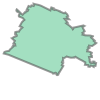

In [1288]:
# scratch

# returns the LFUCG USB polygon
city_boundary_gdf.geometry.iloc[0]

In [1289]:
# query to check for disconnected census blocks, parks
# watch out for census block 210670040072013 — it has 38 people and no arcs? 
# in fact, many of the exterior census block have this problem 
# this leads us to a "what do we mean by 'Lexington'?" dispute

check1_df = (
    nodes_df
    .query("node_type == 'origin'") # what type of node? 
    .merge(
        arcs_gdf, # merge with arcs
        left_on='id_string', # that match id_string
        right_on='tail_id', # on their tail (outgoing)
        how='left', # keep origins no matter what
        indicator=True # create indicator column
    ) 
    .query("_merge == 'left_only'")
    #.query("netflow != 0") # how many of the edgeless have no people? 223 — this doesn't fix the problem
)
check1_df.head()
# map the census blocks with no outgoing edges
# several of these are 'typical' census blocks — inside the circle and everything
# limiting to USB gets us down to 52

,id_string,name,node_type,netflow,lat,lon,arc_id,tail_id,tail_lat,tail_lon,head_id,head_lat,head_lon,arc_type,in_H,in_H2,dist,geometry,_merge


In [1290]:
# scratch
#check1_df.to_csv('data/exports/non-empty_edgeless_origin_nodes.csv', index=False)

In [1291]:
# repeat for destination nodes
check2_df = (
    nodes_df
    .query("node_type == 'destination'") # what type of node? 
    .merge(
        arcs_gdf, # merge with arcs
        left_on='id_string', # that match id_string
        right_on='head_id', # on their head (incoming)
        how='left', # keep destinations no matter what
        indicator=True # create indicator column
    ) 
    .query("_merge == 'left_only'")
)
check2_df.info()
# only 4 parks without incoming edges
# i think i'm okay with excluding these parks (practically or otherwise)
# USB limitations get us down to 0

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   id_string  0 non-null      object  
 1   name       0 non-null      object  
 2   node_type  0 non-null      object  
 3   netflow    0 non-null      int64   
 4   lat        0 non-null      object  
 5   lon        0 non-null      object  
 6   arc_id     0 non-null      object  
 7   tail_id    0 non-null      object  
 8   tail_lat   0 non-null      object  
 9   tail_lon   0 non-null      object  
 10  head_id    0 non-null      object  
 11  head_lat   0 non-null      float64 
 12  head_lon   0 non-null      float64 
 13  arc_type   0 non-null      object  
 14  in_H       0 non-null      int64   
 15  in_H2      0 non-null      int64   
 16  dist       0 non-null      float64 
 17  geometry   0 non-null      geometry
 18  _merge     0 non-null      category
dtypes: category(1), float64(3), geometry(1), int64

In [1292]:
# looks like the arboretum has multiple representative points?

In [1293]:
# the 200m threshold seems too large for downtown, too small for out of town

# idea 1: ignore "too large" downtown, use Urban Service Boundary
# i think we should limit to USB regardless, but this doesn't totally resolve the issue

# idea 2: create tiered thresholds
# idea 3: for now, manually connect edgeless nodes

In [1294]:
# double check that the census block names are reall the last 7(?) digits of GEOID20

In [1295]:
# check that the netflow values are all integers # by construction
# some origin nodes may have 'true' netflow? as of Nov 20 # fixed
# check lengths of arcs in intermediate_arcs_gdf (what units?) # km by construction of CRS

### Edgeless node checks

In [1296]:
# using a stratified radius to connect origins and destinations to the cycle network 
# this leaves some census blocks disconnected
# for now just gonna connect them manually using a higher threshold
# in the future, i want a more systematic approach

In [1297]:
# manual node connection

# move this up to node section
# exclude partially USB-contained census blocks first

In [1298]:
# query to check for disconnected census blocks

disconnected_origins_df = (
    nodes_df
    .query("node_type == 'origin'") # what type of node? 
    .merge(
        arcs_gdf, # merge with arcs
        left_on='id_string', # that match id_string
        right_on='tail_id', # on their tail (outgoing)
        how='left', # keep origins no matter what
        indicator=True # create indicator column
    ) 
    .query("_merge == 'left_only'")
)

In [1299]:
# scratch 

# what are the id_strings of the edgeless origins?
#edgeless_origin_list = disconnected_origins_df['id_string'].tolist()
# note that the query step is prob redundant thx to the for loop structure's effect on oi_distance_df

# how far are the remaining edgeless nodes from their closest node?
new_df = (
    oi_distance_df
    .merge(origin_nodes_projected_gdf, left_on='row_index', right_on='index') # merge with census data
    .merge(intermediate_nodes_projected_gdf, left_on='col_index', right_on='index') # merge with cycle data 
    #.query("id_string_x in @edgeless_origin_list") 
    .groupby('id_string_x')
    .agg(min_distance = ('distance','min'))
    .reset_index()
)

In [1300]:
new_df
# census block 210670039182019 is not entirely inside the USB (but it's rep point is)
# can we query the census block more directly for USB containment?
# this would remove 39182019, 39182039, 40051003 
# 37042039 is fully in the USB and we could fix with a 301 or something

,id_string_x,min_distance


In [1301]:
# scratch
#disconnected_origins_df.to_csv('data/exports/edgeless_origin_nodes2.csv', index=False)

In [1302]:
# check for edgeless dest nodes

disconnected_dest_df = (
    nodes_df
    .query("node_type == 'dest'") # what type of node? 
    .merge(
        arcs_gdf, # merge with arcs
        left_on='id_string', # that match id_string
        right_on='head_id', # on their head (incoming)
        how='left', # keep destinations no matter what
        indicator=True # create indicator column
    ) 
    .query("_merge == 'left_only'")
)
disconnected_dest_df

,id_string,name,node_type,netflow,lat,lon,arc_id,tail_id,tail_lat,tail_lon,head_id,head_lat,head_lon,arc_type,in_H,in_H2,dist,geometry,_merge


### One way concerns

In [1303]:
# scratch 
# debugging solver error re bidihi edges

# first problem index pair
# (76993.0, 76040.0)
# look for these edges in bidihi and associated data structures
# dist_ list
# arcs
# arcs_gdf

# bidi_high_stress_arcs
#if (76993.0, 76040.0) in bidi_high_stress_arcs:
#    print('oui')
#else:
#    print('non')

# not in bidi_high_stress_arcs
# reflected by arcs_gdf H2=0

In [1304]:
# scratch 
# debugging solver error re bidihi edges 

arcs_gdf.query("tail_id == 76993").query("head_id == 76040")
# something fishy is going on here
# it appears that this arc shows up in ft and tf (double check)
# but one of these versions has H2=1 and the other has H2=0

,arc_id,tail_id,tail_lat,tail_lon,head_id,head_lat,head_lon,arc_type,in_H,in_H2,dist,geometry
59267,"(76993.0, 76040.0)",76993.0,38.059879,-84.465461,76040.0,38.059846,-84.46556,intermediate,0,0,9.320275,"LINESTRING (-84.46546 38.05988, -84.46556 38.0..."


In [1305]:
# scratch 
# debugging solver error re bidihi edges 

# are there are one ways for cars and bikes that are high stress? 
debug_gdf = (
    pfb_gdf
    #.query("ONE_WAY_CA.isnull() == False") # one way for cars
    #.query("ONE_WAY.isnull() == False") # one way for bikes
    #.query("FT_SEG_STR > 1") # high stress in the from-to direction (only one to-from instance)
    .query("FT_SEG_STR.isnull() == False")
    .query("TF_SEG_STR.isnull() == False")
    .query("FT_SEG_STR != TF_SEG_STR") # stress levels different
    .assign(
        dist = (
            pfb_gdf.to_crs("ESRI:102003") # project for distance calculation
            .geometry.length
        )
    )
    # min of directional stress == 1
    #[['NAME','FT_SEG_STR','TF_SEG_STR','geometry','dist']]
    .groupby(['NAME'])
    .agg(
        total_distance=('dist', 'sum')
    )
    .reset_index()
)
debug_gdf#.to_file('data/exports/stress_mismatch.shp')

,NAME,total_distance
0,Bryan Avenue,122.315252
1,East Fourth Street,87.838215
2,Hilltop Avenue,78.469943


In [1306]:
summarized_df = (
    pfb_gdf
    #.query("ONE_WAY_CA == 'YES'")
    #.query("ONE_WAY != 'ft'")
    #[['ONEWAY','ONE_WAY','NAME','dist']]
    .assign(
        dist = (
            pfb_gdf.to_crs("ESRI:102003") # project for distance calculation
            .geometry.length
        )
    )
)
summarized_df#.to_file('data/exports/one_way_deduct.shp')
# why is this returning a totally NaN df?

,ROAD_ID,OSM_ID,TAG_ID,NAME,INTERSECTI,INTERSE_01,ONEWAY,TDG_ID,FUNCTIONAL,PATH_ID,...,FT_PARK,TF_PARK,FT_SEG_STR,FT_INT_STR,TF_SEG_STR,TF_INT_STR,XWALK,JOB_ID,geometry,dist
0,1.0,16169228.0,110,Lin Wal Road,5374.0,8763.0,NO,9b076314-493f-41ca-868c-9f75954f0b49,residential,NaN,...,NaN,NaN,1.0,1,1.0,1,NaN,5a751b59-ecc5-4924-b7bc-9002321614c0,"LINESTRING (722138.333 4217491.548, 722062.723...",106.466072
1,2.0,288211647.0,112,None,7894.0,23999.0,NO,da95d307-4c4f-4cc9-908a-fece94bd8ddd,path,1.0,...,NaN,NaN,1.0,1,1.0,1,NaN,5a751b59-ecc5-4924-b7bc-9002321614c0,"LINESTRING (719263.420 4211239.645, 719277.308...",19.797888
2,3.0,258150215.0,112,None,44442.0,22981.0,YES,bf3de0fd-fd27-4bab-9f65-e35f5384401f,path,659.0,...,NaN,NaN,1.0,3,NaN,1,NaN,5a751b59-ecc5-4924-b7bc-9002321614c0,"LINESTRING (719937.392 4205928.867, 719939.506...",21.663028
3,65.0,16097102.0,108,Hutchison Road,124.0,48.0,UNKNOWN,30f02070-dcdd-4d1a-b326-b70678128d4e,secondary,NaN,...,NaN,NaN,3.0,1,3.0,1,NaN,5a751b59-ecc5-4924-b7bc-9002321614c0,"LINESTRING (731970.025 4225135.487, 731977.494...",50.542355
4,67.0,16097102.0,108,Hutchison Road,38746.0,49.0,UNKNOWN,22d4c8d5-2d14-4ef1-a167-0d8f3d062f9a,secondary,NaN,...,NaN,NaN,3.0,1,3.0,1,NaN,5a751b59-ecc5-4924-b7bc-9002321614c0,"LINESTRING (732528.350 4224784.227, 732544.819...",123.310326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51585,2349.0,42090057.0,105,None,40493.0,2122.0,YES,83e50462-d084-4d8f-8b07-2ad455e298f6,trunk_link,NaN,...,NaN,NaN,3.0,1,NaN,1,NaN,5a751b59-ecc5-4924-b7bc-9002321614c0,"LINESTRING (723422.616 4213644.103, 723428.744...",126.876702
51586,11961.0,42090058.0,105,None,20492.0,20494.0,YES,e44777fb-562f-4e01-b1fd-c56d067cc658,trunk_link,NaN,...,NaN,NaN,3.0,1,NaN,1,NaN,5a751b59-ecc5-4924-b7bc-9002321614c0,"LINESTRING (723408.229 4213616.876, 723400.123...",9.532647
51587,12979.0,42090058.0,105,None,20494.0,20495.0,YES,55228151-9afe-4bc5-88ad-0f4f705bda38,trunk_link,NaN,...,NaN,NaN,3.0,1,NaN,1,NaN,5a751b59-ecc5-4924-b7bc-9002321614c0,"LINESTRING (723400.123 4213621.963, 723389.489...",11.693574
51588,22942.0,42090058.0,105,None,2292.0,20492.0,YES,d7b0fa7c-a98a-4ac9-9afb-794954af2a20,trunk_link,NaN,...,NaN,NaN,3.0,1,NaN,1,NaN,5a751b59-ecc5-4924-b7bc-9002321614c0,"LINESTRING (723421.525 4213605.712, 723418.519...",17.340624


### Flow balance constraint debugging

In [1307]:
# check node_to_netflow, node_to_outgoing_arcs, node_to_incoming_arcs dicts for inconsistencies/errors
# ensure all nodes have valid flow balance constraints
#node_to_incoming_arcs
#netflow_list
debug_df = (
    nodes_df
    .groupby(['node_type'])
    .agg(
        avg_netflow=('netflow','mean'),
        node_count=('netflow','count'),
        total_netflow=('netflow','sum'),
        min_netflow=('netflow','min'),
        max_netflow=('netflow','max')
    )
    .reset_index()
)
debug_df

,node_type,avg_netflow,node_count,total_netflow,min_netflow,max_netflow
0,destination,0.000000,121,0,0,0
1,dummy_node,-138647.000000,1,-138647,-138647,-138647
2,intermediate,0.000000,35785,0,0,0
3,origin,53.822593,2576,138647,1,1079


In [1308]:
# verify that all nodes have incoming edges 
debug_df = (
    nodes_df
    .query("node_type != 'origin'") # remove sources 
    # merge w arcs on head
    .merge(
        arcs_gdf, 
        left_on='id_string', 
        right_on='head_id',
        how='left', # keep nodes no matter what
        indicator=True # create indicator column
    ) 
    .groupby(['id_string'])
    .agg(in_deg=('head_id','count')) # count incoming
    .reset_index()
    .query("in_deg == 0")
    .merge(nodes_df,left_on='id_string',right_on='id_string')
    #.to_csv('data/exports/no_incoming.csv', index=False)
)
debug_df

,id_string,in_deg,name,node_type,netflow,lat,lon
0,2185,0,,intermediate,0,38.098669,-84.485842
1,5302,0,,intermediate,0,38.044373,-84.57427
2,25281,0,,intermediate,0,38.045133,-84.497359
3,31062,0,,intermediate,0,38.034447,-84.524518
4,35557,0,,intermediate,0,38.03991,-84.548402
5,42893,0,,intermediate,0,37.959125,-84.38201
6,68988,0,,intermediate,0,38.005638,-84.400897
7,69280,0,,intermediate,0,37.985766,-84.499789


In [1309]:
# verify that all nodes have outgoing edges 
debug_df = (
    nodes_df
    .query("node_type != 'dummy_node'") # remove sink 
    # merge w arcs on tail
    .merge(
        arcs_gdf, 
        left_on='id_string', 
        right_on='tail_id',
        how='left', # keep nodes no matter what
        indicator=True # create indicator column
    ) 
    .groupby(['id_string'])
    .agg(out_deg=('tail_id','count')) # count outgoing
    .reset_index()
    .query("out_deg == 0")
    .merge(nodes_df,left_on='id_string',right_on='id_string')
    #.to_csv('data/exports/no_outgoing.csv', index=False)
)
debug_df

,id_string,out_deg,name,node_type,netflow,lat,lon
0,2298,0,,intermediate,0,38.045792,-84.565119
1,27492,0,,intermediate,0,38.030731,-84.527831
2,31063,0,,intermediate,0,38.03452,-84.524463
3,42894,0,,intermediate,0,37.959091,-84.382036
4,43995,0,,intermediate,0,38.025719,-84.58056
5,46833,0,,intermediate,0,38.018928,-84.50576
6,75049,0,,intermediate,0,38.082987,-84.443411
7,93838,0,,intermediate,0,38.001846,-84.448038


# Export

In [1310]:
# export nodes and arcs to look at on Google Earth for further reality checking
# convention for file versions: increase version number *before* running new export

#origin_nodes_df.to_csv('exports/origin_nodes4.csv', index=False)
# version number is behind #intermediate_nodes_df.to_csv('exports/intermediate_nodes2.csv', index=False)
#dest_nodes_df.to_csv('exports/dest_nodes2.csv', index=False)
#nodes_df.to_csv('exports/nodes_test.csv', index=False)

# version number is behind #origin_to_intermediate_arcs_gdf.to_file('exports/origin_to_intermediate_arcs6.shp')
# version number is behind #intermediate_arcs_gdf.to_file('exports/intermediate_arcs5.shp')
#intermediate_arcs_gdf.query('in_H == 1').to_file('exports/high_stress_arcs2.shp')
#intermediate_arcs_gdf.query('in_H2 == 1').to_file('exports/bidihi_arcs2.shp')
#intermediate_to_dest_arcs_gdf.to_file('exports/intermediate_to_dest_arcs5.shp')
#dest_to_dummy_arcs_gdf.to_file('exports/dest_to_dummy_arcs2.shp')
#arcs_gdf.to_file('exports/arcs2.shp')

#pfb_ft_gdf.to_file('exports/int_ft_arcs_test.shp')
#pfb_tf_gdf.to_file('exports/int_tf_arcs_test.shp')

In [1311]:
# export long cells's outputs?

# Anything else? 

In [1312]:
# clean up parameter subsection

In [1313]:
# look for repeated data wrangling steps and move them up the chain to minimize repetion

In [1314]:
# clean up USB filters? either move up, or remove commented out lines in arc creation

In [1315]:
# if not using H2: remove code

In [1316]:
# remove v1 (or v2) Solver Object code 

# Solver

In [1317]:
# define budget
# eventually this might get moved to Setup>Parameters
# for now, use 15% of total cost 
budget = 0.15*sum(high_stress_arc_to_cost.values())
#budget/ (10**6) # comes out to about $129 million

# factor by which a low stress path would need to exceed a high stress route in order for someone to choose the shorter high stress route. 
# equiv: someone would be willing f times further in order to stay on a low stress path
f = 1.25 
# see https://transweb.sjsu.edu/sites/default/files/1005-low-stress-bicycling-network-connectivity.pdf
# page 3

In [1318]:
# set up the model
model = pyo.ConcreteModel()

# variables
model.x = pyo.Var(arcs, domain=pyo.NonNegativeIntegers)
model.y = pyo.Var(high_stress_arcs, domain=pyo.Binary)
model.z = pyo.Var(high_stress_arcs, domain=pyo.Binary)

# objective function
def obj_rule(model):
    return (sum(arc_to_dist[i,j]*model.x[i,j] for i,j in arcs) 
            + sum((f-1)*arc_to_dist[i,j]*model.z[i,j] for i,j in high_stress_arcs)
           )
    
model.obj = pyo.Objective(rule=obj_rule,sense=pyo.minimize)

# constraints
## flow balance
def flow_balance_rule(model,node):
    return (
        sum(model.x[node,j] for node,j in node_to_outgoing_arcs[node]) - sum(model.x[i,node] for i,node in node_to_incoming_arcs[node]) == node_to_netflow[node]
    )

model.flow_balance = pyo.Constraint(nodes,rule=flow_balance_rule)

## use only low stress arcs or upgraded high stress arcs, or incur a penalty
def low_stress_rule(model,i,j): 
    return model.z[i,j] >= model.x[i,j] - total_pop*model.y[i,j]  

model.low_stress = pyo.Constraint(high_stress_arcs,rule=low_stress_rule)

## upgrade bidirectional high stress arcs in pairs
## temporarily suspending this constraint
#def bidirectional_upgrade_rule(model,i,j):
#    return model.y[i,j] <= model.y[j,i]

#model.bidirectional_upgrade = pyo.Constraint(bidi_high_stress_arcs,rule=bidirectional_upgrade_rule)

## stay on budget
def budget_rule(model): 
    return sum(high_stress_arc_to_cost[i,j]*model.y[i,j] for i,j in high_stress_arcs) <= budget 

model.budget = pyo.Constraint(rule=budget_rule)

In [1319]:
# run the solver
#result = pyo.SolverFactory("glpk").solve(model, tee = True)

In [1320]:
# run the solver — try gurobi instead
solver_name = 'gurobi'
solver = pyo.SolverFactory(solver_name)
solver.options['TimeLimit'] = 600
solver.options['MIPGap'] = 0.01
results = solver.solve(model, tee=True)

Set parameter Username
Set parameter LicenseID to value 2612524
Academic license - for non-commercial use only - expires 2026-01-21
Read LP format model from file /var/folders/d7/x2vjzx3d2qd85_gll3w99lyr0000gn/T/tmpusdl7wgi.pyomo.lp
Reading time = 0.14 seconds
x1: 51199 rows, 119110 columns, 237968 nonzeros
Set parameter TimeLimit to value 600
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  600
MIPGap  0.01

Optimize a model with 51199 rows, 119110 columns and 237968 nonzeros
Model fingerprint: 0x2eb8d8bb
Variable types: 0 continuous, 119110 integer (25430 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [1e-01, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+08]
Found heuristic solution: objective 1.386470e+10
Presolve removed

In [1321]:
# scratch
# some ideas from Daphne

# suppose you have a set of binary variables called x indexed over the set S:
# model.x = pyo.Var(X, domain = pyo.Binary)
# model.y = pyo.Var(high_stress_arcs, domain=pyo.Binary)
# and you want to find all of the indices for which the variable is 1:

upgraded = []
for s in high_stress_arcs:
    if pyo.value(model.y[s]) >= 1:
        upgraded.append(s)

#Or, you could do a list comprehension:
#[s for s in S if pyo.value(model.x[s])>=1]

In [1322]:
# scratch
#upgraded

In [1323]:
# scratch
# do some data wrangling on nonzero_integer_vars
df = (pd.DataFrame(upgraded, columns=['tail', 'head']))
df

,tail,head
0,20707.0,2943.0
1,6360.0,4754.0
2,6705.0,7852.0
3,18443.0,20341.0
4,44967.0,20419.0
...,...,...
1949,5941.0,30403.0
1950,8897.0,6012.0
1951,4191.0,8897.0
1952,9272.0,46025.0


In [1324]:
# scratch
# some ideas from Daphne
#Of course, if it's not just a binary variable and you want the variable value, too, you can add a tuple to your list:

nonzero_flow = []
for s in arcs:
    if pyo.value(model.x[s]) >= 1:
        nonzero_flow.append((s,pyo.value(model.x[s])))

#Or:
#[(s,pyo.value(model.x[s])) for s in S if pyo.value(model.x[s])>=1]

In [1325]:
# scratch
#nonzero_flow

In [1326]:
# scratch
# do some data wrangling on nonzero_integer_vars
df = (
    pd.DataFrame(nonzero_flow, columns=['arc', 'flow'])
    .assign(
        tail_id=lambda x: x['arc'].str[0],
        head_id=lambda x: x['arc'].str[1],
        tail_prefix=lambda x: x['arc'].apply(lambda arc: str(arc[0]).startswith('21067'))
    )
    .query("head_id == 'dummy_node'")
    .query("tail_prefix == True")
    .merge(nodes_df, left_on='tail_id', right_on='id_string')
    #.to_csv('exports/used_debug_arcs8.csv', index=False)
)
df

,arc,flow,tail_id,head_id,tail_prefix,id_string,name,node_type,netflow,lat,lon
0,"(210670023022012, dummy_node)",1.0,210670023022012,dummy_node,True,210670023022012,23022012,origin,17,+37.9948903,-084.4697778
1,"(210670037042044, dummy_node)",1.0,210670037042044,dummy_node,True,210670037042044,37042044,origin,1,+38.0752658,-084.5317487
2,"(210670038023034, dummy_node)",3.0,210670038023034,dummy_node,True,210670038023034,38023034,origin,3,+38.1030132,-084.4827682
3,"(210670039062021, dummy_node)",1.0,210670039062021,dummy_node,True,210670039062021,39062021,origin,25,+37.9979663,-084.4005220
4,"(210670039062023, dummy_node)",1.0,210670039062023,dummy_node,True,210670039062023,39062023,origin,69,+38.0004936,-084.4041638


In [1327]:
# scratch 
# compare to the nodes we (tried to) remove
census_block_debug_list
# lol it's exactly the same arcs ... what's going wrong? 

['210670032021009',
 '210670037042044',
 '210670038023034',
 '210670039062021',
 '210670039062023',
 '210670040013000']

In [1328]:
# scratch 
# export stuff

#origin_to_intermediate_arcs_gdf.to_file('exports/origin_to_intermediate_arcs10.shp')
#intermediate_arcs_gdf.to_file('exports/intermediate_arcs9.shp')
#intermediate_nodes_df.to_csv('exports/intermediate_nodes5.csv', index=False)

In [1329]:
# scratch
# check that all census blocks start w 21067
# indeed they do
(
    nodes_df
    .assign(
        tail_prefix=lambda x: x['id_string'].astype(str).apply(lambda arc: arc.startswith('21067'))
    )
    .query("node_type == 'origin'")
    .query("tail_prefix == True")
)

,id_string,name,node_type,netflow,lat,lon,tail_prefix
0,210670001011000,01011000,origin,16,+38.0515839,-084.4955876,True
1,210670001011001,01011001,origin,4,+38.0511768,-084.4951252,True
2,210670001011003,01011003,origin,21,+38.0507292,-084.4962901,True
3,210670001011004,01011004,origin,21,+38.0502042,-084.4976164,True
4,210670001011005,01011005,origin,4,+38.0497116,-084.4952586,True
...,...,...,...,...,...,...,...
2571,210670042102014,42102014,origin,22,+37.9693580,-084.5450581,True
2572,210670042102015,42102015,origin,1,+37.9713357,-084.5455059,True
2573,210670042102016,42102016,origin,49,+37.9698114,-084.5469592,True
2574,210670042102017,42102017,origin,105,+37.9763679,-084.5463857,True
